Random seed= 999


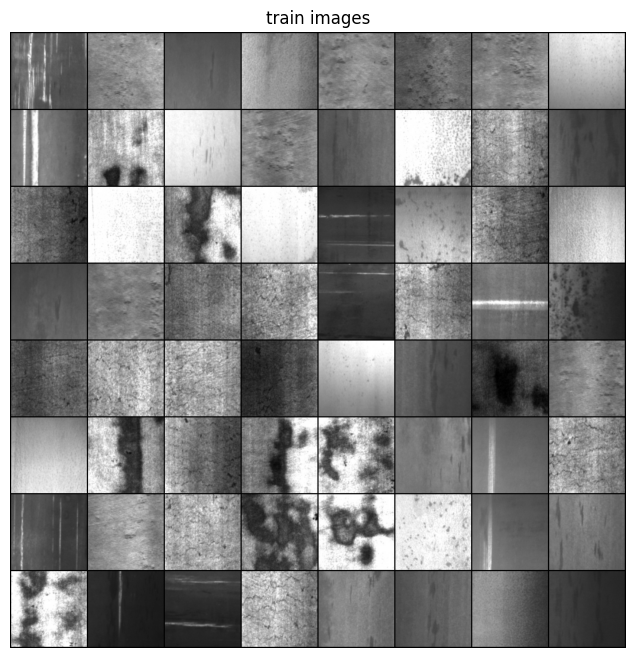

netG Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (4): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(256,

KeyboardInterrupt: 

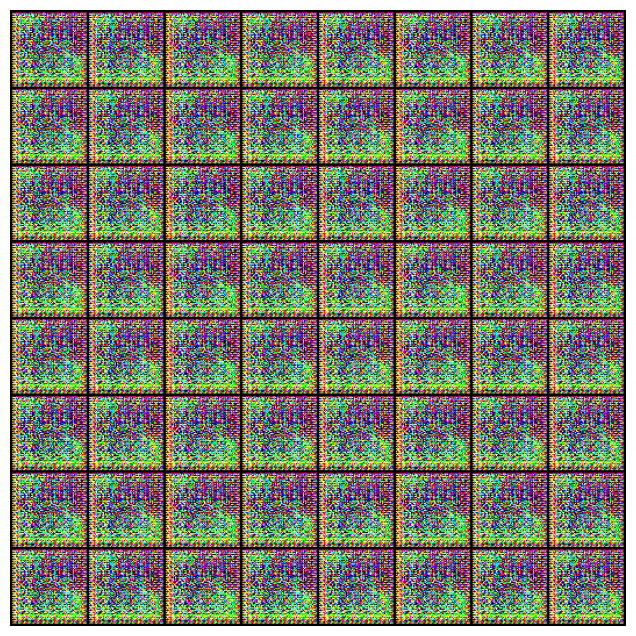

In [50]:
#1.创建一个result文件夹来保存训练过程
import copy
import os
import time
 
#2.导入所需的包
import random
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import torchvision.utils as vutils
import matplotlib.pyplot as plt
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
 
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(in_features),
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()
        self.nz = nz
        self.ngf = ngf
        self.nc = nc

        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            # State size. (ngf*8) x 4 x 4
            ResidualBlock(ngf * 8),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            # State size. (ngf*4) x 8 x 8
            ResidualBlock(ngf * 4),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            # State size. (ngf*2) x 16 x 16
            ResidualBlock(ngf * 2),
            nn.ConvTranspose2d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            # State size. (ngf) x 32 x 32
            ResidualBlock(ngf),
            nn.ConvTranspose2d(ngf, nc, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # State size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.nc = nc
        self.ndf = ndf
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, kernel_size=4, stride=2, padding=1, bias=False),  # 64*32*32
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),  # 128*16*16
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=2, padding=1, bias=False),  # 256*8*8
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, kernel_size=4, stride=2, padding=1, bias=False),  # 512*4*4
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=1, padding=0, bias=False),  # 1*1*1
            nn.Sigmoid(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten()
        )

    def forward(self, input):
        # Ensure the output is flattened to match the label shape
        output = self.main(input)
        return output.view(-1)
#3.基本参数配置
manualSeed=999
print("Random seed=",manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
dataroot="F:\model\yolo11\my-data\demo"  #数据集所在的路径
workers=0  #数据加载进程数
batch_size=64  #batch size大小
image_size=128  #图片的大小
nc=3  #图片的通道数
nz=100  #一张图片的随机噪声
ngf=64  #生成器generator的特征大小
ndf=64  #判别器discrimination的特征大小
num_epoch=150  #训练的次数
lr=0.0003  #学习率
beta1=0.5  #数据优化
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
 
#4.导入数据集
dataset=dset.ImageFolder(root=dataroot,
                         transform=transforms.Compose([
                             transforms.Resize(image_size),
                             transforms.CenterCrop(image_size),
                             transforms.ToTensor(),
                             transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                         ]))
 
dataloader=DataLoader(dataset=dataset,batch_size=batch_size,shuffle=True,num_workers=workers)
 
#5.查看数据
real_batch=next(iter(dataloader))
plt.figure(figsize=(8,8))#设置画布
plt.axis("off")#关闭坐标轴
plt.title("train images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64],padding=2,normalize=True).cpu(),(1,2,0)))
#make_grid()把多个图片放在一张图上
plt.show()
 
#6.初始化生成器和判别器
#实例化生成器
netG = Generator(nz, ngf, nc).to(device)
#netG.apply(weights_init)
print("netG",netG)
#实例化判别器
netD = Discriminator(nc, ndf).to(device)
#netD.apply(weights_init)
print("netD=",netD)
 
#7.定义损失函数
criterion=nn.BCELoss()
 
#8.开始训练
#创建一批噪声数据用来生成
fixed_noise=torch.randn(size=(64,nz,1,1),device=device)
#建立真假标签值
real_label=1.0
fake_label=0.0
#建立优化模型
optimizer_D=optim.Adam(netD.parameters(),lr=lr,betas=(beta1,0.999))
optimizer_G=optim.Adam(netG.parameters(),lr=lr,betas=(beta1,0.999))
#建立一些列表跟踪进程
img_list=[]
G_losses=[]
D_losses=[]
iters=0
print("starting Training 开始训练")
for epoch in range(num_epoch):
    import time
    start=time.time()
    for i ,data in enumerate(dataloader,0):
        #1.更新判别器D (1) Update D network: maximize log(D(x))
        # + log(1 - D(G(z)))
        #1.1真实图片的损失
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        output = netD(real_cpu)
        # print("Real image batch dimensions:", output.shape)
        D_real_loss = criterion(output, label)
        D_real_loss.backward()
        #1.2fake图片的损失
        noise=torch.randn(b_size,nz,1,1,device=device)#64*100*1*1
        fake=netG(noise)
        label.fill_(fake_label)#
        output=netD(fake.detach()).view(-1)
        D_fake_loss=criterion(output,label)
        D_fake_loss.backward()
        D_G_z1=output.mean().item()
        D_loss=(D_real_loss+D_fake_loss)
        optimizer_D.step()
        #2.更新generator的network(2) Update G network: maximize log(D(G(z)))
        netG.zero_grad()
        label.fill_(real_label)
        output=netD(fake).view(-1)
        G_loss=criterion(output,label)
        G_loss.backward()
        D_G_z2=output.mean().item()
        optimizer_G.step()
        #输出训练结果
        if i %20==0:
            print("epoch:",epoch,"num_epoch:",num_epoch,
                  "batch:",i,
                  "D_real_loss:",D_real_loss.item(),
                  "D_fake_loss:",D_fake_loss.item(),
                  "D_loss:",D_loss.item(),
                  "G_loss:",G_loss.item())
        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())
        #检查fixe_noise在generator上的结果
        if(iters%20==0) or (i==len(dataloader)-1):
            with torch.no_grad():
                fake=netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake,padding=2,normalize=True))
            i=vutils.make_grid(fake,padding=2,normalize=True)
            fig=plt.figure(figsize=(8,8))
            plt.imshow(np.transpose(i,(1,2,0)))
            plt.axis("off")
            root="./result/train"
            plt.savefig(root+str(epoch)+"_"+str(iters)+".png")
            plt.close(fig)
        iters+=1
    print("time=",time.time()-start)
 
#9.绘制损失曲线
plt.figure(figsize=(10,5))
plt.title("generator and Discriminator loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("loss")
plt.legend()
plt.show()
 
#10.真假图片对比
# Grab a batch of real images from the dataloader
# real_batch = next(iter(dataloader))
# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()
#保存训练好的模型
torch.save(netG,"./netg"+str(num_epoch)+".pt")
torch.save(netD,"./netd"+str(num_epoch)+".pt")